# Backlog Analyse & Voorspelling – Servicedesk Wire Solutions

Dit notebook analyseert de ontwikkeling van de totale backlog binnen de servicedesk van Wire Solutions en geeft een eenvoudige voorspelling van de backlogontwikkeling bij ongewijzigd beleid.

De analyse is gebaseerd op volledige maanden van februari t/m oktober 2019.
De maand november 2019 is expliciet uitgesloten, omdat deze maand onvolledig is in de dataset en daarmee geen representatief beeld geeft van instroom en afhandeling.

### Het doel van dit notebook is:
- inzicht krijgen in de ontwikkeling van de backlog over de tijd;
- het vaststellen van het tempo van afbouw;
- het maken van een realistische, uitlegbare voorspelling.

## Imports en basisinstellingen

Voor deze analyse maken we gebruik van standaard Python-libraries voor data-analyse, visualisatie en regressie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 2. Data inladen

De dataset (data-backlog.csv) bevat per incident:
- een uniek incidentnummer;
- een startdatum (registratiemoment);
- een einddatum (afsluitmoment).

Andere beschikbare velden zijn in dit notebook bewust niet gebruikt, omdat deze analyse zich uitsluitend richt op de totale backlogontwikkeling.

In [2]:
FILE_PATH = "data-backlog.csv"

df = pd.read_csv(FILE_PATH)
df.columns = [c.strip() for c in df.columns]

df.head()

,incident nummer,eind datum,start datum,Incident categorie,Thema
0,1188362,2019-02-01 00:00:00,2019-02-01 00:00:00,Functioneel beheer,Werkplek & Functionele Bedrijfsapplicaties
1,1188366,2019-02-01 00:00:00,2019-02-01 00:00:00,2e lijns (Doorgezette incidenten),Werkplek & Functionele Bedrijfsapplicaties
2,1188368,2019-02-01 00:00:00,2019-02-01 00:00:00,Hardware / Werkplekbeheer,Toegang & Communicatieplatforms
3,1188370,2019-02-01 00:00:00,2019-02-01 00:00:00,Hardware / Werkplekbeheer,Werkplek & Functionele Bedrijfsapplicaties
4,1188373,2019-02-01 00:00:00,2019-02-01 00:00:00,2e lijns (Doorgezette incidenten),Werkplek & Functionele Bedrijfsapplicaties


## 3. Datums parsen en validatie

De datums in de CSV zijn opgeslagen in ISO-formaat (YYYY-MM-DD HH:MM:SS).
Deze worden omgezet naar datetime-objecten zodat tijdsanalyses mogelijk zijn.

Na het parsen controleren we of er ongeldige of ontbrekende datums zijn.

In [3]:
df["start_dt"] = pd.to_datetime(df["start datum"], errors="coerce")
df["eind_dt"]  = pd.to_datetime(df["eind datum"], errors="coerce")

df[["start_dt", "eind_dt"]].isna().sum()

start_dt    0
eind_dt     0
dtype: int64

De dataset bevat geen ontbrekende start- of einddatums, waardoor de analyse volledig kan worden uitgevoerd.

## 4. Instroom en afhandeling per maand (context)

In deze stap berekenen we:
- Instroom: incidenten met een startdatum in een maand;
- Afhandeling: incidenten met een einddatum in een maand.

Deze cijfers geven context aan de backlogontwikkeling, maar vormen niet de primaire maat voor de trendanalyse.

In [4]:
df["start_maand"] = df["start_dt"].dt.to_period("M")
df["eind_maand"]  = df["eind_dt"].dt.to_period("M")

instroom = df.groupby("start_maand")["incident nummer"].nunique()
afhandeling = df.groupby("eind_maand")["incident nummer"].nunique()

maand_df = pd.concat([instroom, afhandeling], axis=1)
maand_df.columns = ["instroom", "afhandeling"]

maand_df

,instroom,afhandeling
2019-02,2671.0,2156
2019-03,2891.0,2736
2019-04,2559.0,2651
2019-05,2513.0,2357
2019-06,3027.0,3112
2019-07,2876.0,2967
2019-08,2889.0,3043
2019-09,2941.0,3204
2019-10,3391.0,3419
2019-11,NaN,113


## 5. Backlog op maandultimo

De backlog wordt gedefinieerd als:
- Het aantal incidenten dat op de laatste dag van de maand nog openstaat.

Een incident telt mee in de backlog wanneer:
- de startdatum vóór of op de maandultimo ligt;
- de einddatum ná de maandultimo ligt.

In [5]:
min_date = df["start_dt"].min()
max_date = df["eind_dt"].max()

month_ends = pd.date_range(min_date, max_date, freq="ME")

records = []
for d in month_ends:
    open_cnt = df[
        (df["start_dt"] <= d) &
        (df["eind_dt"] > d)
    ].shape[0]
    records.append((d, open_cnt))

backlog_df = (
    pd.DataFrame(records, columns=["maandultimo", "backlog"])
      .set_index("maandultimo")
)

backlog_df

,backlog
maandultimo,
2019-02-28,515
2019-03-31,670
2019-04-30,578
2019-05-31,734
2019-06-30,649
2019-07-31,558
2019-08-31,404
2019-09-30,141
2019-10-31,113


## 6. Uitsluiten van november (onvolledige maand)

De maand november 2019 bevat geen volledige instroom en is daardoor methodologisch ongeschikt voor trend- en voorspellingsanalyse.

Om consistent te blijven met de rest van het onderzoek, nemen we alleen volledige maanden mee.

In [6]:
backlog_df = backlog_df.loc["2019-02-28":"2019-10-31"]
backlog_df

,backlog
maandultimo,
2019-02-28,515
2019-03-31,670
2019-04-30,578
2019-05-31,734
2019-06-30,649
2019-07-31,558
2019-08-31,404
2019-09-30,141
2019-10-31,113


## 7. Trendanalyse met lineaire regressie

Om de ontwikkeling van de backlog te analyseren, gebruiken we een lineaire regressie op tijd.

#### Motivatie
- De backlog vormt een korte tijdreeks zonder duidelijke seizoenspatronen;
- Het doel is inzicht in de globale trend, niet exacte voorspellingen;
- Lineaire regressie is transparant, uitlegbaar en geschikt voor beleidsanalyse.

#### Feature engineering

In [7]:
pred_df = backlog_df.copy()
pred_df["t"] = np.arange(len(pred_df))

X = pred_df[["t"]]
y = pred_df["backlog"]

#### Model trainen

In [8]:
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
print(f"Trend (Δ backlog per maand): {slope:.2f}")

Trend (Δ backlog per maand): -61.98


De regressie toont een gemiddelde afname van circa 62 incidenten per maand, wat wijst op een structurele afbouw van de backlog.

## 8. Voorspelling (2 maanden vooruit)

Op basis van de vastgestelde trend wordt een voorspelling gemaakt voor de twee maanden na oktober 2019.

Aannames:
- het afhandeltempo blijft gelijk;
- er is geen structurele toename van incidentcomplexiteit;
- de backlog kan niet negatief worden.

In [9]:
n_future = 2

last_backlog = pred_df["backlog"].iloc[-1]

future_backlog = [
    max(last_backlog + slope * i, 0)
    for i in range(1, n_future + 1)
]

future_dates = pd.date_range(
    pred_df.index[-1] + pd.offsets.MonthEnd(1),
    periods=n_future,
    freq="ME"
)

forecast_df = pd.DataFrame(
    {"voorspelde_backlog": future_backlog},
    index=future_dates
)

forecast_df

,voorspelde_backlog
2019-11-30,51.016667
2019-12-31,0.000000


De voorspelling laat zien dat:
- eind november circa 51 incidenten resteren;
- eind december de backlog naar verwachting volledig is weggewerkt.

## 9. Visualisatie: historie en voorspelling

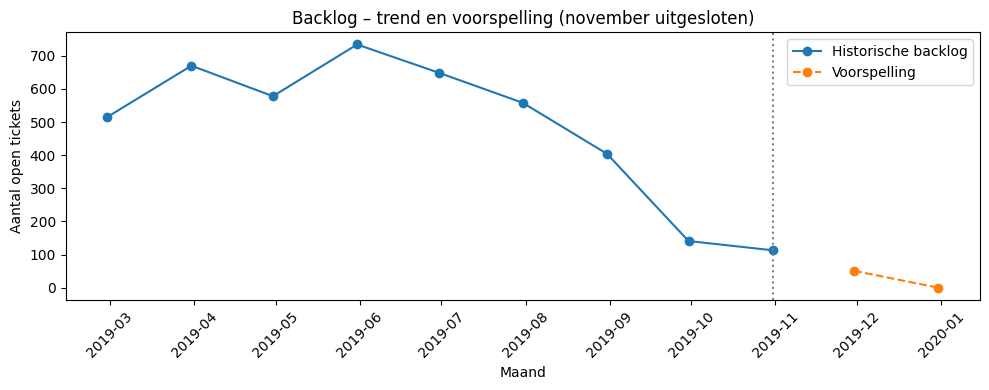

In [10]:
plt.figure(figsize=(10,4))

plt.plot(
    pred_df.index,
    pred_df["backlog"],
    marker="o",
    label="Historische backlog"
)

plt.plot(
    forecast_df.index,
    forecast_df["voorspelde_backlog"],
    marker="o",
    linestyle="--",
    label="Voorspelling"
)

plt.axvline(pred_df.index[-1], linestyle=":", color="gray")

plt.title("Backlog – trend en voorspelling (november uitgesloten)")
plt.xlabel("Maand")
plt.ylabel("Aantal open tickets")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 10. Conclusie

Op basis van deze analyse kan worden geconcludeerd dat:
- De backlog binnen de servicedesk in de eerste helft van 2019 is opgebouwd, maar vanaf de zomer structureel is afgenomen.
- Over volledige maanden bedraagt de gemiddelde afname circa 62 incidenten per maand.
- Bij voortzetting van het huidige afhandeltempo wordt de resterende backlog naar verwachting binnen twee maanden volledig weggewerkt.
- Er is geen sprake van een structureel oplopende backlog bij ongewijzigd beleid, maar van een tijdelijke capaciteitsmismatch die succesvol is gecorrigeerd.

Deze analyse benadrukt het belang van datagedreven monitoring van backlogontwikkeling en ondersteunt beleidskeuzes gericht op structurele stabiliteit in plaats van reactieve opschaling.